<a href="https://colab.research.google.com/github/YoonhoNam/hufsclass/blob/master/ch3_01_linear_regression_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.2. Linear Regression Implementation from Scratch
- From scratch는 것은 갖추어진 것이 없는 상태에서 시작한다는 의미로, 기초적인 것부터 직접 구현하면서 실제 머신러닝 모델이 어떻게 동작하는 지를 이해하는 것이 목표입니다.
- 앞으로 우리가 사용할 패키지들은 이번 단원에서 다룰 대부분의 내용을 보다 쉽고 편하게 구현할 수 있으나, 그것들이 실제 어떻게 동작하는 지를 이해하기 위해 직접 구현해보는 것이 분명히 도움이 될 것입니다.


- 시작을 위해 필수적인 패키지들을 불러오도록 합니다. 

In [0]:
import torch
import random
from matplotlib import pyplot as plt

## 3.2.1. Generating the Dataset

- w1x1+w2x2+b의 형태로 표현되는 선형모델로 시작할 것입니다. 
- 우리는 2개의 숫자를 가지는 example을 1000개를 생성할 것입니다. 
- 파라미터는 각 2개의 숫자(feature)에 대한 weight 2개와 bias1개로 총 3개가 될 것입니다.
- 우리가 예측하고자 하는 모델의 **w** = [2, -3.4], b=4.2 이라고 합시다. 실제 우리가 풀게 될 대부분의 문제들은 parameter의 값을 정확히 모르는 상태로 시작하게 되겠지만, 지금은 알고 있다고 가정을 하겠습니다.
-  가상으로 만들 label y는 노이즈를 더하게 되면 아래와 같은 식으로 표현될 수 있습니다:
> **y** = **Xw** + b + e.
- 여기서 노이즈성분 e는 feature 및 label에 포함될 수 있는 측정에러로 간주해 볼 수 있습니다. 



- 아래는 우리가 모델의 실제 파라미터값을 알고 있다고 가정하고, 가상의 데이터를 노이즈를 추가하여 만드는 함수를 정의하고, 그 함수를 이용하여 features, labels를 1000개의 example에 대해 생성하는 과정입니다.

In [0]:
def synthetic_data(w, b, num_examples):
  X = torch.zeros(size=(num_examples,len(w))).normal_(mean=0,std=1)
  y = torch.matmul(X, w) + b
  y += torch.zeros(size=y.shape).normal_(mean=0,std=0.01)
  return X, y

true_w = torch.tensor([2, -3.4])
true_b = 4.2

features, labels = synthetic_data(true_w, true_b, 1000)

- n번째 example에 대해 생성된 값을 출력하면, feature는 2개의 성분(숫자)을 가지는 vector이고 label은 1개의 성분(숫자)로 이루어진 scalar임을 확인할 수 있습니다. 

In [3]:
n = 25
print('example ',n,'\n','features:',features[0],'\nlabel:',labels[0])

example  25 
 features: tensor([-0.7342, -0.1447]) 
label: tensor(3.2052)


- scatterplot을 이용하여 각 feature와 label의 관계를 살펴볼 수 있습니다. 
- 만약, 노이즈가 추가되지 않았다면 어떤 형태의 관계를 볼 수 있을까요? synthetic_data함수의 노이즈 추가 부분을 변경하여 결과를 확인해 봅시다.

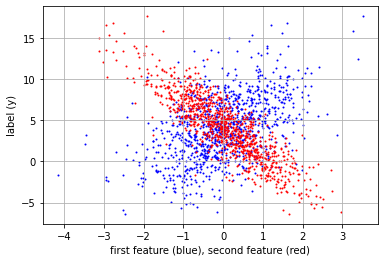

In [4]:
fig=plt.figure()
ax=fig.gca()
ax.scatter(features[:,0].numpy(), labels.numpy(),s=1,color='b')
ax.scatter(features[:,1].numpy(), labels.numpy(),s=1,color='r')
ax.set_xlabel('first feature (blue), second feature (red)')
ax.set_ylabel('label (y)')
ax.grid('both')

- 아래와 같이 두 feature에 대한 결과를 subplot을 이용하여 각각 표현할 수도 있습니다.

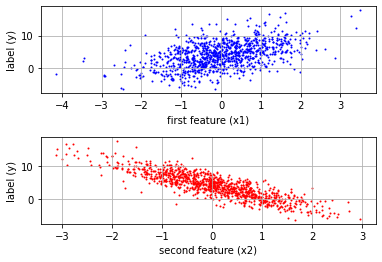

In [5]:
fig,((ax1, ax2))=plt.subplots(2,gridspec_kw={'hspace':0.5})
ax1.scatter(features[:,0].numpy(), labels.numpy(),s=1,color='b')
ax1.set_xlabel('first feature (x1)')
ax1.set_ylabel('label (y)')
ax1.grid('both')
ax2.scatter(features[:,1].numpy(), labels.numpy(),s=1,color='r')
ax2.set_xlabel('second feature (x2)')
ax2.set_ylabel('label (y)')
ax2.grid('both')

## 3.2.2. Readint the Dataset

- 위에서 우리가 생성한 1000개의 example을 우리는 training data라고 생각해 볼 수 있습니다. 
- Training data를 이용해 모델의 파라미터를 업데이트할 때 우리는 minibatch를 활용할 것입니다.
- minibatch는 미리 정의한 개수의 데이터를 불러와 이로부터 loss function을 계산한 후, model의 파라미터를 업데이트하는 것입니다.
- example이 1000개이고, minibatch의 size가 10이라고 하면 만약 중복을 허용하지 않고 데이터를 추출한다면 우리는 총 100번의 과정을 통해 1000개의 example을 모두 한 번씩 model parameter의 업데이트에 기여하게 만들 수 있을 것입니다.
- 이때 minibatch 데이터를 추출하는 방식은 순서대로 할 수도 있고, 랜덤으로 할 수도 있고, 중복추출을 허용하거나 그렇지 않을 수도 있을 것 입니다.

- 데이터를 추출할 수 있는 방법은 다양하게 구현될 수 있습니다. 아래의 함수는 하나의 예로 구현된 것입니다. batchsize 숫자를 정의하고, 우리가 가지고 있는 feature, label데이터를 모두 입력으로 넣어 정의하였습니다.
- batchsize의 숫자는 우리가 gpu를 활용할 경우에 연산의 효율성과 관련이 있습니다. 
- minibatch에서 각각의 example에 대한 예측값을 계산하고, loss function을 계산하고, loss function의 gradient를 계산하는 과정은 독립적으로 수행할 수 있기 때문에 gpu를 통해 병렬화를 하게 되면 동시에 여러 example에 대한 연산을 수행할 수 있기 때문입니다.

In [0]:
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  # The examples are read at random, in no particular order
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
    yield features[batch_indices], labels[batch_indices]

- 처음 접하는 함수에 대한 기능 및 활용방법을 확인하는 유용한 방법은 출력을 해보는 것입니다. 
- list, random.shuffle, range라는 함수가 처음 등장하였는데 print를 이용하여 역할을 추측해 봅시다.

In [7]:
list0 = list(range(10))
print('before shuffle: ',list0)
random.shuffle(list0)
print('after shuffle: ',list0,'\n')

r = range(0,19,4)
print('r:',r)
print('for i in range r')
for i in r:
  print(i)

before shuffle:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
after shuffle:  [9, 5, 8, 1, 7, 0, 2, 3, 6, 4] 

r: range(0, 19, 4)
for i in range r
0
4
8
12
16


- data_iter라는 함수가 우리가 의도한 기능을 수행하지 아래의 for문을 통해 확인해 볼 수 있습니다. break를 넣었기 때문에 첫 minibatch의 결과만을 보여줍니다. break를 제거하고 실행하면 모든 minibatch의 결과를 확인할 수 있습니다.


In [8]:
batch_size = 5
for X, y in data_iter(batch_size, features, labels):
  print('features: ', X,'\n','labels: ',y)
  break

features:  tensor([[-0.8761, -1.7096],
        [-0.8977,  0.9741],
        [-1.7690, -0.9339],
        [ 1.4098,  2.2548],
        [-0.1386,  0.0197]]) 
 labels:  tensor([ 8.2611, -0.9141,  3.8342, -0.6587,  3.8561])


## 3.2.3. Initializing Model Parameters

- 모델을 훈련시키기에 앞서 파라미터들을 초기화하여야 합니다. 우리는 2개의 w와 1개의 b에 대한 초기화를 해주어야 합니다.
- w는 평균이 0이고 표준편차가 0.01인 normal distribution의 랜덤변수로 초기화하고, b는 0으로 초기화하겠습니다.
- Gradient를 계산하는 것은 PyTorch에서 제공하는 autograd를 사용하려고 합니다. 따라서, reauires_grad를 True로 해주어야 합니다.


In [9]:
w = torch.zeros(size=(2,1)).normal_(std=0.01)
w.requires_grad_(True)
b = torch.zeros(size=(1,),requires_grad=True)
print('initial values of w: ', w)
print('initial value of b: ', b)

initial values of w:  tensor([[0.0213],
        [0.0057]], requires_grad=True)
initial value of b:  tensor([0.], requires_grad=True)


## 3.2.4. Defining the Model
- 우리의 linear model은 데이터들을 표현하는 matrix X와 parameter를 표현하는 vector w의 matrix-vector multiplication에 또 다른 parameter b(scalar)를 더하는 것으로 정의할 수 있습니다.
- y = Xw + b
- PyTorch에서는 아래와 같은 코드로 간단히 정의해 줄 수 있습니다.

In [0]:
def linreg(X, w, b):
  return torch.matmul(X,w)+b

- 간단한 예제로 결과를 확인해 봅시다.

In [11]:
print(linreg(torch.tensor([[2,3],[3,4]]),torch.tensor([4,2]),torch.tensor(3)))

tensor([17, 23])


## 3.2.5. Defining the Loss Function

- 모델의 파라미터를 업데이트하기 위해서는 loss function으로부터 gradient를 계산하여야 합니다.
- 우리는 아래와 같은 squared loss function을 정의할 것입니다. 
- y의 shape을 바꿔주는 것은 연산을 위해서입니다. shape이 다를 경우 연산이 되지 않을 수 있습니다.

In [0]:
def squared_loss(y_hat, y):
  return (y_hat-y.reshape(y_hat.shape))**2/2

- 아래의 코드를 실행하여 shape과 관련된 문제를 이해해 봅시다. shape이 맞지 않는 상태에서 연산을 하게되면 의도치 않은 결과가 출력될 수 있습니다.

In [13]:
y = torch.tensor([1.,2,3])
y_hat = torch.tensor([[2.],[4],[5]])
print(y)
print(y_hat)
print( (y_hat-y)**2/2 )
print( (y_hat-y.reshape(y_hat.shape))**2/2 )

tensor([1., 2., 3.])
tensor([[2.],
        [4.],
        [5.]])
tensor([[0.5000, 0.0000, 0.5000],
        [4.5000, 2.0000, 0.5000],
        [8.0000, 4.5000, 2.0000]])
tensor([[0.5000],
        [2.0000],
        [2.0000]])


## 3.2.6. Defining the Optimization Algorithm

- 아래는 stochastic gradient descent를 정의한 것입니다. update해야할 params, learning rate lr, batch_size의 3개의 입력을 받아서 params를 새로운 값으로 업데이트합니다.
- param.grad.datz.zero_()는 업데이트가 끝난 후에 grad를 다시 0으로 만들어 줍니다.

In [0]:
def sgd(params, lr, batch_size):
  for param in params:
    param.data -= lr*param.grad/batch_size
    param.grad.data.zero_()

## 3.2.7. Training


### 지금까지 정의한 것들을 통해 우리는 model의 학습을 진행할 수 있습니다.
- 우리는 data X, y를 생성하였습니다. 
- y와 X의 관계를 표현하는 linear model (linreg)를 정의하였습니다. 
- linreg는 3개의 parameter (w1,w2,b)를 가집니다.
- 데이터를 정해진 크기(batch_size)로 랜덤으로 추출하는 함수(data_iter)를 정의하였습니다.
- loss function 및 sgd algorithm을 정의하였습니다.
- 이제 hyper-parameter(num_epochs, batch_size, learning rate)들을 정의하고 학습을 시작하면 됩니다.

> ***아래의 코드는 앞으로 수행할 실습의 기반이 되므로 반드시 완벽하게 이해를 해야 합니다.***


In [15]:
# Initializing parameters
w = torch.zeros(size=(2,1)).normal_(std=0.01)
w.requires_grad_(True)
b = torch.zeros(size=(1,))
b.requires_grad_(True)

lr = 0.03 # Learning rate
num_epochs = 10 # Number of iterations
batch_size = 5
net = linreg # Our fancy linear model
loss = squared_loss # 0.5 (y-y')^2
alg = sgd # stochastic gradient descent

for epoch in range(num_epochs):
  # Assuming the number of examples can be divided by the batch size, all
  # the examples in the training dataset are used once in one epoch
  # iteration. The features and tags of minibatch examples are given by X
  # and y respectively
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X,w,b),y) # Minibatch loss in X and y
    l = l.mean().backward() # Compute gradient on l with respect to [w, b]
    alg([w, b], lr, batch_size)
  with torch.no_grad():
    train_l = loss(net(features,w,b), labels)
    print('epoch %d, loss %f' % (epoch+1, train_l.mean().numpy()))

epoch 1, loss 1.567657
epoch 2, loss 0.154562
epoch 3, loss 0.015316
epoch 4, loss 0.001569
epoch 5, loss 0.000201
epoch 6, loss 0.000065
epoch 7, loss 0.000051
epoch 8, loss 0.000049
epoch 9, loss 0.000049
epoch 10, loss 0.000049


- 이 실습에서는 실제 parameter들을 알고 있습니다. (현실에서는 그런 경우가 거의 없습니다.) 
- 학습된 파라미터들을 실제 값과 비교해 보겠습니다.

In [16]:
print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)

Error in estimating w tensor([0.0006, 0.0004], grad_fn=<SubBackward0>)
Error in estimating b tensor([3.0994e-05], grad_fn=<RsubBackward1>)
